This version is meant to iterate over itself and show at the end a graph of all of the mismatched values based on the number of years
This is the final stage analysis of prediction
We see a massive drop post 1980, which is interesting and may indicate a regime change

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
color_pal = sns.color_palette()

# Parameters
ticker = "^GSPC"  # S&P 500 Index
start_date = "1950-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')  # Use today's date

# Download data
data = yf.download(ticker, start=start_date, end=end_date)

# Use adjusted close price
data = data[['Adj Close']]
data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

# Calculate daily returns
data['Index_Returns'] = data['Adj_Close'].pct_change()
data.dropna(inplace=True)

# Fit Markov Switching Model on full data with switching trend
returns = data['Index_Returns']
full_model = MarkovRegression(returns, k_regimes=2, trend='c', switching_variance=True, switching_trend=True)
full_result = full_model.fit(disp=False)
full_regimes = full_result.smoothed_marginal_probabilities.idxmax(axis=1)

[*********************100%***********************]  1 of 1 completed


C:\Users\NicholasRatti\AppData\Local\Temp\ipykernel_96532\1458006824.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
C:\Users\NicholasRatti\AppData\Local\Temp\ipykernel_96532\1458006824.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Index_Returns'] = data['Adj_Close'].pct_change()
C:\Users\NicholasRatti\AppData\Local\Temp\ipykernel_96532\1458006824.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [7]:
# Prepare a list of split dates from 1980 to 2019, incremented by one year
split_years = list(range(1980, 2020))  # From 1980 to 2019
split_dates = [f"{year}-01-01" for year in split_years]

# Initialize a list to store the results
results = []

In [11]:
# Loop over each split date
for split_date in split_dates:
    print(f"Processing split date: {split_date}")
    # Split data into train and test sets
    train = data.loc[data.index < split_date, 'Index_Returns']
    test = data.loc[data.index >= split_date, 'Index_Returns']
    
    # Skip if training data is too short
    if len(train) < 100:
        print(f"Not enough training data before {split_date}, skipping.")
        results.append({
            'split_date': split_date,
            'num_mismatches': np.nan,
            'test_period_length': len(test),
            'mismatch_percentage': np.nan
        })
        continue
    
    # Fit the Markov Switching Model on the training data with switching trend
    train_model = MarkovRegression(train, k_regimes=2, trend='c', switching_variance=True, switching_trend=True)
    train_result = train_model.fit(disp=False)
    
    # Get the smoothed probabilities and regimes from training data
    smoothed_probs_train = train_result.smoothed_marginal_probabilities
    train_regimes = smoothed_probs_train.idxmax(axis=1)
    
    # Extract the last known state probabilities (at the end of the training data)
    last_probs = smoothed_probs_train.iloc[-1].values  # Convert to NumPy array
    
    # Regime labels (from smoothed probabilities)
    regime_labels = smoothed_probs_train.columns.tolist()  # Should be [0, 1]
    
    # Extract transition probabilities from the model parameters
    params = train_result.params

    # Debug: Print the parameters to check their names
    print("Model parameters:")
    print(params)
    
    # Transition probabilities
    p_00 = params['p[0->0]']  # Probability of staying in Regime 0
    p_10 = params['p[1->0]']  # Probability of moving from Regime 1 to Regime 0
    
    # Probabilities of transitioning to Regime 1
    p_01 = 1 - p_00           # Probability of moving from Regime 0 to Regime 1
    p_11 = 1 - p_10           # Probability of staying in Regime 1
    
    # Construct the transition matrix
    transition_matrix = np.array([
        [p_00, p_01],  # Transitions from Regime 0
        [p_10, p_11]   # Transitions from Regime 1
    ])
    
    # Regime-specific means and variances
    means = [params[f'const[{i}]'] for i in range(2)]      # Updated parameter names
    variances = [params[f'sigma2[{i}]'] for i in range(2)]
    
    # Initialize DataFrame for test data
    test_data = pd.DataFrame(index=test.index)
    test_data['Index_Returns'] = test
    test_data['State_Prob_Regime0'] = np.nan
    test_data['State_Prob_Regime1'] = np.nan
    test_data['Predicted_Regime'] = np.nan
    
    # Initialize state probabilities with the last known probabilities from the training data
    state_probs = last_probs.copy()
    
    # Loop over each date in the test set
    for date in test.index:
        # Predict step: update state probabilities using the transition matrix
        state_probs = np.dot(state_probs, transition_matrix)
        
        # Update step: compute emission probabilities (likelihood of observation given state)
        y = test_data.at[date, 'Index_Returns']
        emission_probs = np.array([
            (1 / np.sqrt(2 * np.pi * variances[i])) * np.exp(-0.5 * ((y - means[i]) ** 2) / variances[i])
            for i in range(2)
        ])
        
        # Update state probabilities with emission probabilities
        state_probs = state_probs * emission_probs
        
        # Normalize state probabilities
        state_probs /= np.sum(state_probs)
        
        # Store the state probabilities in the DataFrame
        test_data.at[date, 'State_Prob_Regime0'] = state_probs[0]
        test_data.at[date, 'State_Prob_Regime1'] = state_probs[1]
        
        # Determine the most likely regime
        most_likely_regime = regime_labels[np.argmax(state_probs)]
        
        # Store the predicted regime in the DataFrame
        test_data.at[date, 'Predicted_Regime'] = most_likely_regime
    
    # Map the predicted regimes to integer type
    test_data['Predicted_Regime'] = test_data['Predicted_Regime'].astype(int)
    
    # Get the 'true' regimes from the full model for the test period
    true_regimes = full_regimes.loc[test.index].astype(int)
    
    # Compare the predicted regimes with the true regimes
    mismatches = test_data['Predicted_Regime'] != true_regimes
    num_mismatches = mismatches.sum()
    test_period_length = len(test_data)
    
    # Store the results
    results.append({
        'split_date': split_date,
        'num_mismatches': num_mismatches,
        'test_period_length': test_period_length,
        'mismatch_percentage': (num_mismatches / test_period_length * 100) if test_period_length > 0 else np.nan
    })

Processing split date: 1980-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.980954
p[1->0]      0.045557
const[0]     0.000630
const[1]    -0.000569
sigma2[0]    0.000025
sigma2[1]    0.000127
dtype: float64
Processing split date: 1981-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.980813
p[1->0]      0.040253
const[0]     0.000633
const[1]    -0.000406
sigma2[0]    0.000025
sigma2[1]    0.000124
dtype: float64
Processing split date: 1982-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.981295
p[1->0]      0.036668
const[0]     0.000620
const[1]    -0.000394
sigma2[0]    0.000026
sigma2[1]    0.000120
dtype: float64
Processing split date: 1983-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.982121
p[1->0]      0.034440
const[0]     0.000590
const[1]    -0.000297
sigma2[0]    0.000026
sigma2[1]    0.000125
dtype: float64
Processing split date: 1984-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.982883
p[1->0]      0.031726
const[0]     0.000574
const[1]    -0.000211
sigma2[0]    0.000027
sigma2[1]    0.000122
dtype: float64
Processing split date: 1985-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.982113
p[1->0]      0.033566
const[0]     0.000533
const[1]    -0.000158
sigma2[0]    0.000027
sigma2[1]    0.000123
dtype: float64
Processing split date: 1986-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.983813
p[1->0]      0.033847
const[0]     0.000522
const[1]    -0.000130
sigma2[0]    0.000028
sigma2[1]    0.000126
dtype: float64
Processing split date: 1987-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.982619
p[1->0]      0.032877
const[0]     0.000541
const[1]    -0.000103
sigma2[0]    0.000028
sigma2[1]    0.000122
dtype: float64
Processing split date: 1988-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.986068
p[1->0]      0.048964
const[0]     0.000509
const[1]    -0.000358
sigma2[0]    0.000034
sigma2[1]    0.000196
dtype: float64
Processing split date: 1989-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985402
p[1->0]      0.047733
const[0]     0.000506
const[1]    -0.000275
sigma2[0]    0.000034
sigma2[1]    0.000192
dtype: float64
Processing split date: 1990-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985429
p[1->0]      0.051728
const[0]     0.000535
const[1]    -0.000353
sigma2[0]    0.000035
sigma2[1]    0.000199
dtype: float64
Processing split date: 1991-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985996
p[1->0]      0.049678
const[0]     0.000540
const[1]    -0.000431
sigma2[0]    0.000035
sigma2[1]    0.000200
dtype: float64
Processing split date: 1992-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.984858
p[1->0]      0.051518
const[0]     0.000534
const[1]    -0.000315
sigma2[0]    0.000035
sigma2[1]    0.000196
dtype: float64
Processing split date: 1993-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985141
p[1->0]      0.052106
const[0]     0.000520
const[1]    -0.000300
sigma2[0]    0.000035
sigma2[1]    0.000196
dtype: float64
Processing split date: 1994-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985179
p[1->0]      0.051855
const[0]     0.000516
const[1]    -0.000288
sigma2[0]    0.000035
sigma2[1]    0.000193
dtype: float64
Processing split date: 1995-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985269
p[1->0]      0.052649
const[0]     0.000504
const[1]    -0.000300
sigma2[0]    0.000035
sigma2[1]    0.000193
dtype: float64
Processing split date: 1996-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985486
p[1->0]      0.051266
const[0]     0.000527
const[1]    -0.000290
sigma2[0]    0.000034
sigma2[1]    0.000189
dtype: float64
Processing split date: 1997-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.984999
p[1->0]      0.052356
const[0]     0.000547
const[1]    -0.000314
sigma2[0]    0.000034
sigma2[1]    0.000187
dtype: float64
Processing split date: 1998-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.984721
p[1->0]      0.049905
const[0]     0.000555
const[1]    -0.000229
sigma2[0]    0.000034
sigma2[1]    0.000185
dtype: float64
Processing split date: 1999-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.984742
p[1->0]      0.051199
const[0]     0.000570
const[1]    -0.000237
sigma2[0]    0.000035
sigma2[1]    0.000194
dtype: float64
Processing split date: 2000-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985332
p[1->0]      0.043394
const[0]     0.000575
const[1]    -0.000146
sigma2[0]    0.000035
sigma2[1]    0.000184
dtype: float64
Processing split date: 2001-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.985938
p[1->0]      0.039826
const[0]     0.000572
const[1]    -0.000171
sigma2[0]    0.000035
sigma2[1]    0.000188
dtype: float64
Processing split date: 2002-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.986243
p[1->0]      0.037253
const[0]     0.000574
const[1]    -0.000210
sigma2[0]    0.000035
sigma2[1]    0.000190
dtype: float64
Processing split date: 2003-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.986908
p[1->0]      0.035855
const[0]     0.000568
const[1]    -0.000292
sigma2[0]    0.000036
sigma2[1]    0.000203
dtype: float64
Processing split date: 2004-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987273
p[1->0]      0.033198
const[0]     0.000576
const[1]    -0.000236
sigma2[0]    0.000036
sigma2[1]    0.000199
dtype: float64
Processing split date: 2005-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987695
p[1->0]      0.033342
const[0]     0.000574
const[1]    -0.000253
sigma2[0]    0.000036
sigma2[1]    0.000200
dtype: float64
Processing split date: 2006-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987778
p[1->0]      0.033619
const[0]     0.000564
const[1]    -0.000249
sigma2[0]    0.000036
sigma2[1]    0.000199
dtype: float64
Processing split date: 2007-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987780
p[1->0]      0.033389
const[0]     0.000567
const[1]    -0.000242
sigma2[0]    0.000036
sigma2[1]    0.000197
dtype: float64
Processing split date: 2008-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987379
p[1->0]      0.033336
const[0]     0.000574
const[1]    -0.000254
sigma2[0]    0.000036
sigma2[1]    0.000195
dtype: float64
Processing split date: 2009-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.989076
p[1->0]      0.036725
const[0]     0.000557
const[1]    -0.000504
sigma2[0]    0.000039
sigma2[1]    0.000259
dtype: float64
Processing split date: 2010-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.989433
p[1->0]      0.035490
const[0]     0.000555
const[1]    -0.000443
sigma2[0]    0.000040
sigma2[1]    0.000270
dtype: float64
Processing split date: 2011-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.989196
p[1->0]      0.035112
const[0]     0.000575
const[1]    -0.000468
sigma2[0]    0.000040
sigma2[1]    0.000267
dtype: float64
Processing split date: 2012-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.989320
p[1->0]      0.034179
const[0]     0.000577
const[1]    -0.000481
sigma2[0]    0.000040
sigma2[1]    0.000272
dtype: float64
Processing split date: 2013-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.989347
p[1->0]      0.034844
const[0]     0.000575
const[1]    -0.000477
sigma2[0]    0.000041
sigma2[1]    0.000272
dtype: float64
Processing split date: 2014-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.989009
p[1->0]      0.036131
const[0]     0.000590
const[1]    -0.000481
sigma2[0]    0.000040
sigma2[1]    0.000271
dtype: float64
Processing split date: 2015-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.988359
p[1->0]      0.037603
const[0]     0.000597
const[1]    -0.000481
sigma2[0]    0.000040
sigma2[1]    0.000266
dtype: float64
Processing split date: 2016-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.988340
p[1->0]      0.037625
const[0]     0.000594
const[1]    -0.000494
sigma2[0]    0.000040
sigma2[1]    0.000266
dtype: float64
Processing split date: 2017-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987968
p[1->0]      0.037971
const[0]     0.000600
const[1]    -0.000487
sigma2[0]    0.000040
sigma2[1]    0.000262
dtype: float64
Processing split date: 2018-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987663
p[1->0]      0.037903
const[0]     0.000607
const[1]    -0.000465
sigma2[0]    0.000039
sigma2[1]    0.000256
dtype: float64
Processing split date: 2019-01-01


C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model parameters:
p[0->0]      0.987446
p[1->0]      0.037441
const[0]     0.000614
const[1]    -0.000498
sigma2[0]    0.000038
sigma2[1]    0.000254
dtype: float64


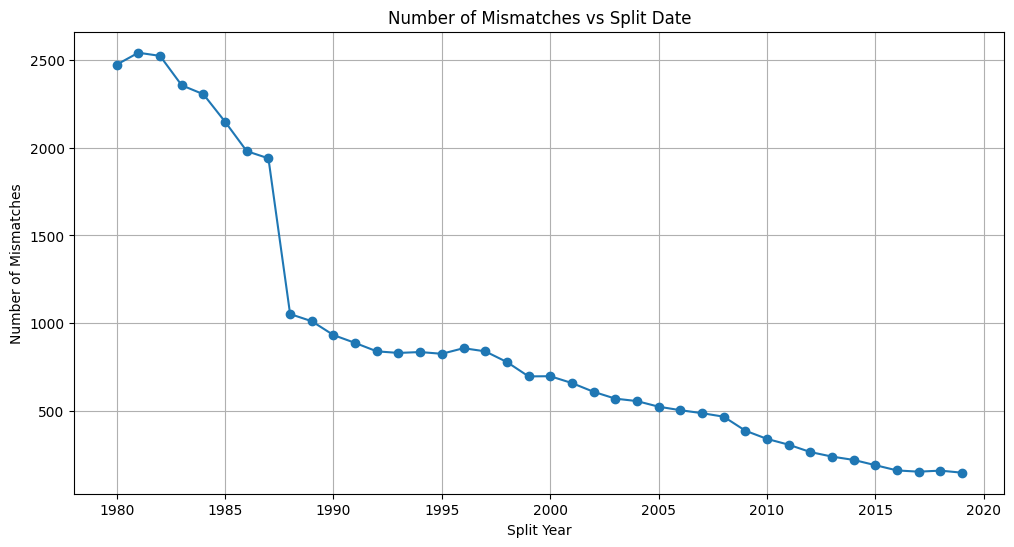

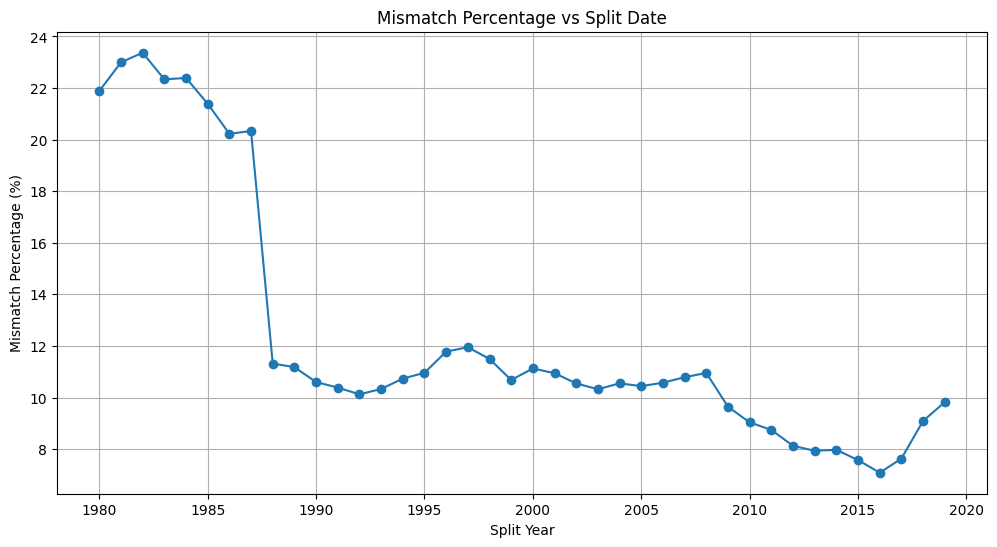

In [12]:
# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df['split_year'] = pd.to_datetime(results_df['split_date']).dt.year

# Plot the number of mismatches vs split date
plt.figure(figsize=(12, 6))
plt.plot(results_df['split_year'], results_df['num_mismatches'], marker='o', linestyle='-')
plt.title('Number of Mismatches vs Split Date')
plt.xlabel('Split Year')
plt.ylabel('Number of Mismatches')
plt.grid(True)
plt.show()

# Alternatively, plot the mismatch percentage
plt.figure(figsize=(12, 6))
plt.plot(results_df['split_year'], results_df['mismatch_percentage'], marker='o', linestyle='-')
plt.title('Mismatch Percentage vs Split Date')
plt.xlabel('Split Year')
plt.ylabel('Mismatch Percentage (%)')
plt.grid(True)
plt.show()